In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(folder, target_size=(256, 256), color_mode='rgb'):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if color_mode == 'grayscale':
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            if color_mode == 'grayscale':
                resized_img = np.expand_dims(resized_img, axis=-1)
            images.append(resized_img)
            filenames.append(filename)
    return images, filenames

# Load and preprocess images (color) and labels (grayscale)
train_images, image_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/images/", color_mode='rgb')
train_labels, label_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/labels/", color_mode='grayscale')

# Ensure that images and labels are matched correctly
assert image_filenames == label_filenames, "Mismatch between image and label files"

# Convert lists to numpy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values
train_images = train_images / 255.0
train_labels = np.where(train_labels > 0, 1, 0).astype(np.float32)  # Binarize labels and convert to float32

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

def deep_lab(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
    conv4 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(up5)
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), padding='same', activation='relu')(up6)
    conv6 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(up7)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = deep_lab()
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

# Check if early stopping was triggered
if len(history.history['val_loss']) < 100:
    print("Early stopping was triggered. Training stopped early.")
else:
    print("Training completed without early stopping.")

# Save the model
model.save("deep_lab_model.h5")
print("Model saved as deep_lab_model.h5")


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - accuracy: 0.5693 - loss: 0.6880 - val_accuracy: 0.4552 - val_loss: 0.6956
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 11s/step - accuracy: 0.3912 - loss: 0.7125 - val_accuracy: 0.5530 - val_loss: 0.6935
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 11s/step - accuracy: 0.6248 - loss: 0.6875 - val_accuracy: 0.8219 - val_loss: 0.6695
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.8236 - loss: 0.6578 - val_accuracy: 0.9025 - val_loss: 0.5555
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 11s/step - accuracy: 0.8570 - loss: 0.6132 - val_accuracy: 0.8915 - val_loss: 0.3421
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.7689 - loss: 1.3321 - val_accuracy: 0.5503 - val_loss: 0.6326
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.6545 - loss: 0.6162 - val_accuracy: 0.6024 - val_loss: 0.6340
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 11s/step - accuracy: 0.6461 - loss: 0.6523 - val_accuracy: 0.9150 - val_loss:

Early stopping was triggered. Training stopped early.
Model saved as deep_lab_model.h5


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import MeanIoU

# Define custom functions to calculate IoU and Dice coefficient
def mean_iou(y_true, y_pred):
    iou = MeanIoU(num_classes=2)
    iou.update_state(y_true, y_pred)
    return iou.result().numpy()

def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)



# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
y_pred = model.predict(X_val)

# Binarize predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate additional evaluation metrics
precision = precision_score(y_val.flatten(), y_pred_binary.flatten())
recall = recall_score(y_val.flatten(), y_pred_binary.flatten())
f1 = f1_score(y_val.flatten(), y_pred_binary.flatten())
iou = mean_iou(y_val, y_pred_binary)
dice = dice_coefficient(y_val, y_pred_binary)

print("Evaluation Metrics:")
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("IoU:", iou)
print("Mean Dice Coefficient:", dice)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8915 - loss: 0.3421
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Evaluation Metrics:
Loss: 0.3421007990837097
Accuracy: 0.8915389776229858
Precision: 0.8491188615248488
Recall: 0.9263580571746511
F1 Score: 0.8860583774287194
IoU: 0.8039343
Mean Dice Coefficient: 0.8860583774287194


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


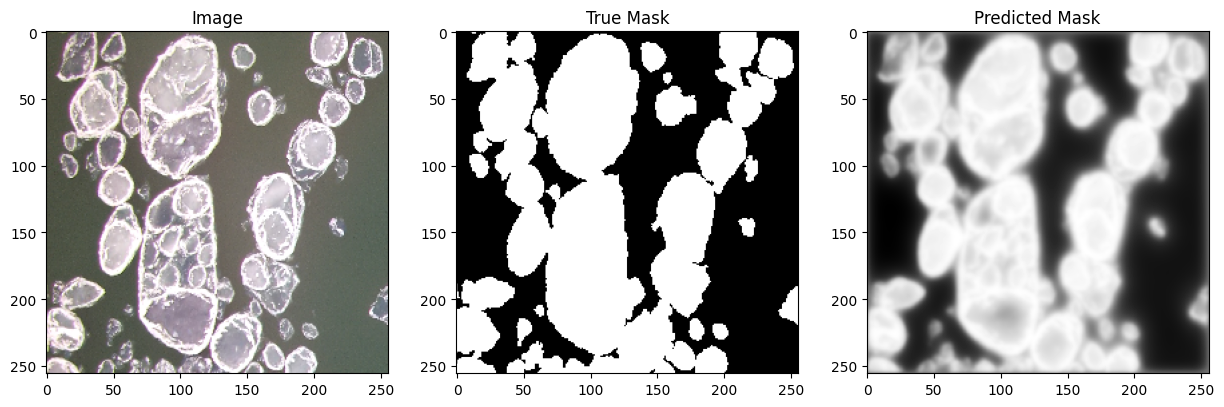

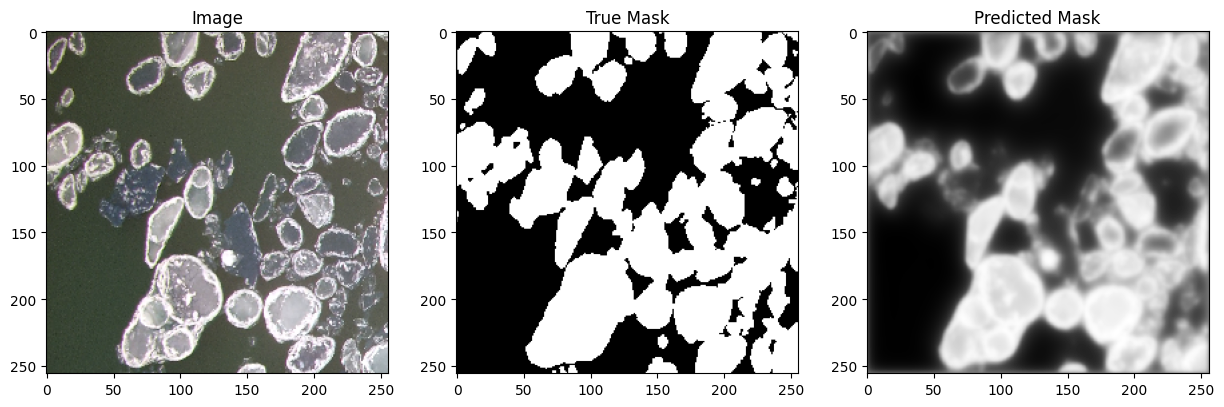

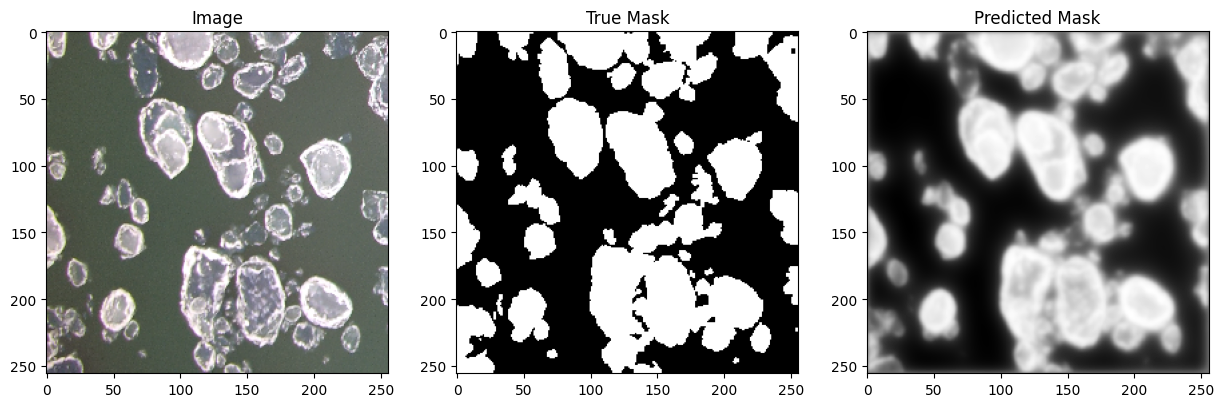

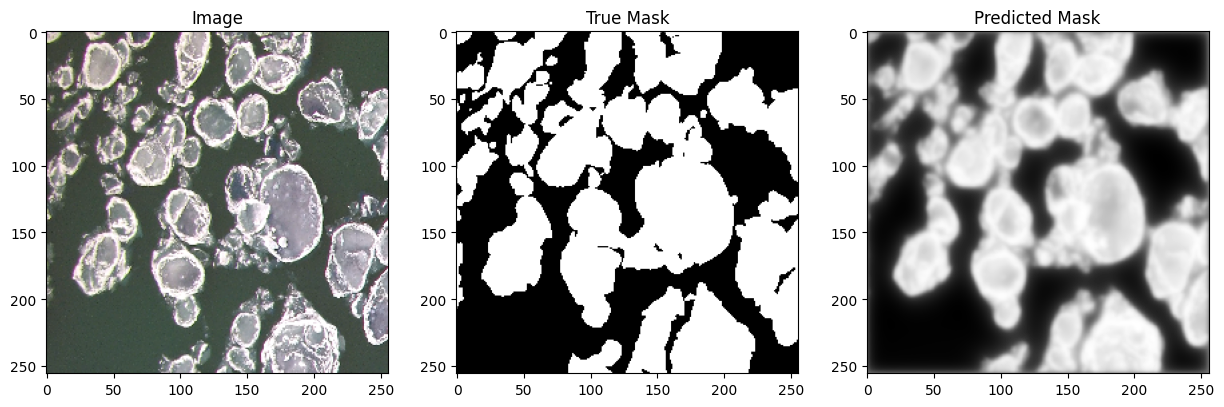

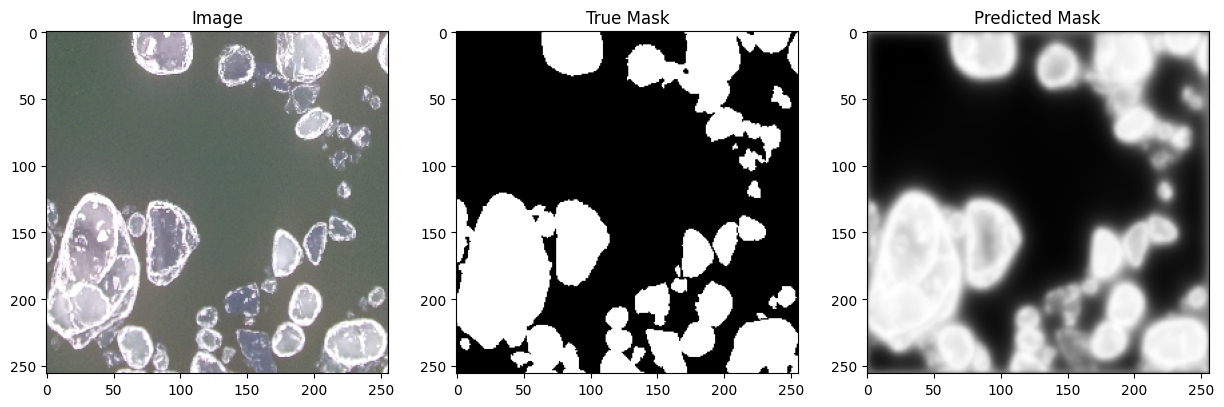

In [3]:
# Predict segmentation masks for validation images
predicted_masks = model.predict(X_val)

# Plotting some results
import matplotlib.pyplot as plt

def plot_results(img, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.show()

# Visualize some results
for i in range(5):  # Plot first 5 results
    plot_results(X_val[i], y_val[i], predicted_masks[i])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 20s/step - accuracy: 0.5018 - dice_coefficient: 0.2664 - loss: 0.6952 - mean_iou: 0.1820 - val_accuracy: 0.4553 - val_dice_coefficient: 0.3180 - val_loss: 0.6761 - val_mean_iou: 0.4553
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 16s/step - accuracy: 0.4434 - dice_coefficient: 0.2543 - loss: 0.6876 - mean_iou: 0.2637 - val_accuracy: 0.4557 - val_dice_coefficient: 0.3328 - val_loss: 0.6572 - val_mean_iou: 0.4555
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 16s/step - accuracy: 0.4308 - dice_coefficient: 0.2758 - loss: 0.6721 - mean_iou: 0.4358 - val_accuracy: 0.5268 - val_dice_coefficient: 0.3438 - val_loss: 0.6322 - val_mean_iou: 0.5037
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 16s/step - accuracy: 0.5609 - dice_coefficient: 0.2978 - loss: 0.6351 - mean_iou: 0.5265 - val_accuracy: 0.6885 - val_dice_coefficient: 0.3945 - val_loss: 0.5409 - val_mean_iou: 0.6013
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 16s/step - accuracy: 0.6026 - dice_coefficient: 0.2891 

Training completed without early stopping.
Model saved as deep_lab_model.h5


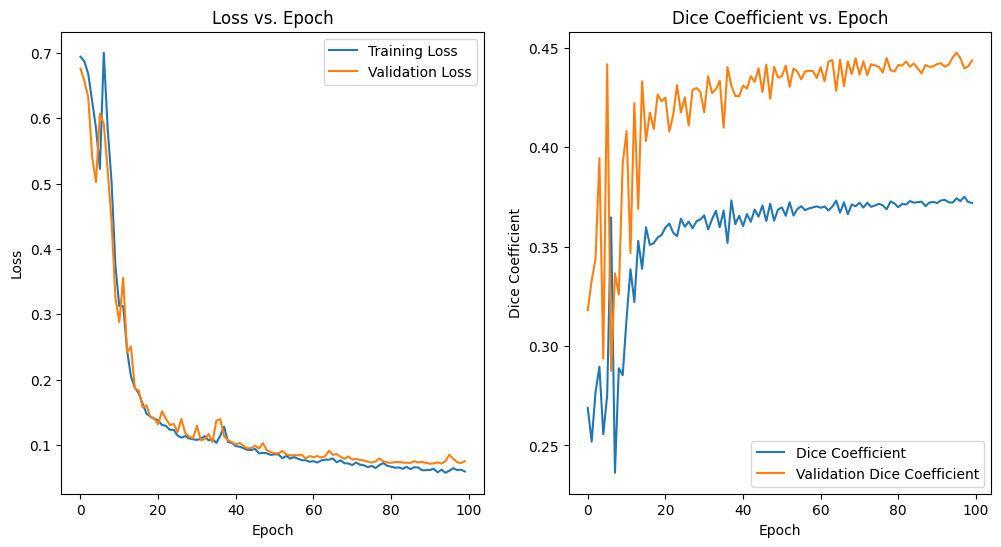

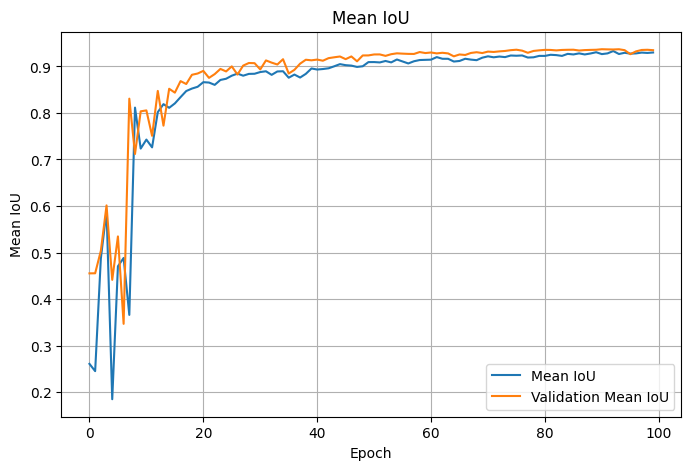

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU

def load_and_preprocess_images(folder, target_size=(256, 256), color_mode='rgb'):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if color_mode == 'grayscale':
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            if color_mode == 'grayscale':
                resized_img = np.expand_dims(resized_img, axis=-1)
            images.append(resized_img)
            filenames.append(filename)
    return images, filenames

# Load and preprocess images (color) and labels (grayscale)
train_images, image_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Documents/Desktop/training/images/", color_mode='rgb')
train_labels, label_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Documents/Desktop/training/labels/", color_mode='grayscale')

# Ensure that images and labels are matched correctly
assert image_filenames == label_filenames, "Mismatch between image and label files"

# Convert lists to numpy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values
train_images = train_images / 255.0
train_labels = np.where(train_labels > 0, 1, 0).astype(np.float32)  # Binarize labels and convert to float32

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

def deep_lab(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
    conv4 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(up5)
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), padding='same', activation='relu')(up6)
    conv6 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(up7)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, mean_iou])

    return model

import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    return (2. * intersection + smooth) / (union + smooth)

def mean_iou(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection
    iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()))
    return iou




# Create the model
model = deep_lab()
model.summary()
# Compile the model with custom metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', mean_iou, dice_coefficient])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

# Check if early stopping was triggered
if len(history.history['val_loss']) < 100:
    print("Early stopping was triggered. Training stopped early.")
else:
    print("Training completed without early stopping.")

# Save the model
model.save("deep_lab_model.h5")
print("Model saved as deep_lab_model.h5")

# Plot training history
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plot Dice coefficient
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'], label='Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient vs. Epoch')
plt.legend()



# Plot Mean IoU
plt.figure(figsize=(8, 5))
plt.plot(history.history['mean_iou'], label='Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()
plt.grid(True)
plt.show()
